# Binned comparisons across all subjects- Correlation Analysis of Segmentation Data
### updated permutation method ( jaccard indices not calculated within each permutation) 9/30/20

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import plotly.plotly as py
import plotly
import os
import glob
import math
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import copy
from random import randrange
from sklearn.metrics import jaccard_score
import random
%autosave 5

Autosaving every 5 seconds


### i. Import data

In [2]:
filename = '/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/analysis/parsing_log_file/pickle/data_dict_pilots_b1_b2_b3_b4_b5_.p'
data_dict = pickle.load( open( filename, "rb" ) )

### ii. import story files

In [3]:
directory_stories = '/Users/alexreblando/Documents/GitHub/ebs/behavioral_August2019/story_xlsx_files_RECORDED'

filenames_stories = glob.glob(directory_stories + '/*.xlsx')

dfs_stories = []
    
for filename in filenames_stories:
    dfs_stories.append(pd.read_excel(filename))

### iii. Exclusions
#### a. exclude participants who only pressed '1' or '9'

In [4]:
keys_to_del = []
for key in data_dict:
    kp = data_dict[key]['story_presses']
    check_kp = len(set(kp))
    if check_kp == 1:
        print(key)
        print(data_dict[key]['prolific_id'].iloc[0])
        keys_to_del.append(key)
        
for i in range(0, len(keys_to_del)):
    del data_dict[keys_to_del[i]]

/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/pilot2/8/PARTICIPANT_1_online_exp_2020-05-11_12h52.50.131
5cf0a300b094d700183e4d54
/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_b1/33/145_1_online_exp_2020-06-10_15h14.14.911
5ec18c4c2f44695b38204649
/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_b1/33/171_1_online_exp_2020-06-10_21h32.27.534
5de12fbfe4f42a1842172d7a
/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_b3/45/418_1_online_exp_2020-07-16_09h12.22.806
5eb5dafddac6754c4ee9d0d7


#### b. Exclude participants who don't answer short answers

In [5]:
del data_dict['/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_b1/33/73_1_online_exp_2020-06-10_14h37.05.252']
del data_dict['/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_b2/30/199_1_online_exp_2020-06-24_20h41.05.680']
del data_dict['/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_b3/45/345_1_online_exp_2020-07-16_09h07.09.087']

In [ ]:
#### d. (exclude participants who answered got 4 or more of the distractor words wrong ) not including this

In [ ]:
exclusions = []

for key in data_dict:
    #get distractor answers
    d1 = data_dict[key]['distractor1'].iloc[0]
    d2 = data_dict[key]['distractor2'].iloc[0]
    d3 = data_dict[key]['distractor3'].iloc[0]
    d4 = data_dict[key]['distractor4'].iloc[0]
    d5 = data_dict[key]['distractor5'].iloc[0]
    
    #set count to 0
    count = 0
    
    #test for correctness
    if d1 != '"accoutrements"':
        count += 1
    else:
        pass
    if d2 != '"tintinnabulation"':
        count += 1
    else:
        pass
    if d3 != '"hippocampus"':
        count += 1
    else:
        pass
    if d4 != '"brigadeiro"':
        count += 1
    else:
        pass
    if d5 != '"muffuletta"':
        count += 1
    else:
        pass
    
    #test if count is greater than or equal to 4 and if count is, then exclude the participant
    if count > 4:
        print(key)
        print(data_dict[key]['prolific_id'].iloc[0])
        exclusions.append(data_dict[key]['prolific_id'].iloc[0])
    else:
        pass

#### d. Pickle data_dict in order to get group counts

In [8]:
pickle.dump( data_dict, open( 'check', "wb" ) )

# I. Separating the Priming Groups For Each Story
## A. group stories by subject and priming type
#### - output: loc_keys_r

In [9]:
loc_keys_r = dict()
soc_keys_r = dict()
none_keys_r = dict()
all_keys_r = dict()

for key in data_dict:
    this_story = data_dict[key]['story'].iloc[0]
    keys = data_dict[key]['story_presses']
    p_type = data_dict[key]['p_type'].iloc[0]
    #print out the filenames and prolific ids of people who did not press "9" once
    occurrences = np.count_nonzero(keys == 9)
    if occurrences == 0:
        print(key)
        print(data_dict[key]['prolific_id'].iloc[0])
    #put all story keys in the same dictionary regardless of priming
    if this_story in all_keys_r:
        all_keys_r[this_story] = np.concatenate((all_keys_r[this_story],keys[:,np.newaxis]), axis=1)
    else:
        all_keys_r[this_story] = keys[:, np.newaxis]
    #organize keys by priming type
    #no prime
    if p_type == 0:
        if this_story in none_keys_r:
            none_keys_r[this_story] = np.concatenate((none_keys_r[this_story],keys[:,np.newaxis]), axis=1)
        else:
            none_keys_r[this_story] = keys[:, np.newaxis]
    #loc prime
    elif p_type == 1:
        if this_story in loc_keys_r:
            loc_keys_r[this_story] = np.concatenate((loc_keys_r[this_story],keys[:,np.newaxis]), axis=1)
        else:
            loc_keys_r[this_story] = keys[:, np.newaxis]
    #soc prime
    elif p_type == 2:
        if this_story in soc_keys_r:
            soc_keys_r[this_story] = np.concatenate((soc_keys_r[this_story],keys[:,np.newaxis]), axis=1)
        else:
            soc_keys_r[this_story] = keys[:, np.newaxis]

### i. Finding the number of participants in each category for each story
#### -output sums[story] = [total # of participants, no prime, loc primed, soc primed]

In [10]:
sums = {}

for key in all_keys_r:
    this_sum = []
    x, y = all_keys_r[key].shape
    this_sum.append(y)
    if key in none_keys_r:
        x, y = none_keys_r[key].shape
        this_sum.append(y)
    else:
        this_sum.append(0)
    if key in loc_keys_r:
        x, y = loc_keys_r[key].shape
        this_sum.append(y)
    else:
        this_sum.append(0)
    if key in soc_keys_r:
        x, y = soc_keys_r[key].shape
        this_sum.append(y)
    else:
        this_sum.append(0)
    sums[key] = this_sum

## B. Convert keypresses from '9's and '1's to '1's and '0's
#### - output loc_keys
#### - WARNING: you can only run this once!!!!!! if you run twice, you must start from the beginning

In [11]:
loc_keys = dict()
soc_keys = dict()
none_keys = dict()
all_keys = dict()

#all keys
for key in all_keys_r:
    this_array = copy.deepcopy(all_keys_r[key])
    this_array[this_array ==1] = 0
    this_array[this_array == 9] = 1
    all_keys[key] = this_array   
    
#none keys
for key in none_keys_r:
    this_array = copy.deepcopy(none_keys_r[key])
    this_array[this_array ==1] = 0
    this_array[this_array == 9] = 1
    none_keys[key] = this_array   
    
#loc keys
for key in loc_keys_r:
    this_array = copy.deepcopy(loc_keys_r[key])
    this_array[this_array ==1] = 0
    this_array[this_array == 9] = 1
    loc_keys[key] = this_array   
    
#soc keys
for key in soc_keys_r:
    this_array = copy.deepcopy(soc_keys_r[key])
    this_array[this_array ==1] = 0
    this_array[this_array == 9] = 1
    soc_keys[key] = this_array   

# IV. Correlation Analysis
## A. Creating partipant x sentence array for each story 
## -organized with No Prime participants first, followed by, Location Primed, and then Social Primed

In [13]:
keypress_array = {}
summary_vals = {}

for key in all_keys:
    # Index keypresses for each story
    none = none_keys[key].T
    n_none, y = none.shape
    loc = loc_keys[key].T
    n_loc, y = none.shape
    soc = soc_keys[key].T
    n_soc, y = none.shape
    # Concatening keypresses
    final = np.concatenate((none,loc,soc), axis = 0)
    # Putting the final array in a dictionary
    keypress_array[key] = final
    # Putting summary vals together
    summary_vals[key] = np.array([n_none, n_loc, n_soc])

## B. Correlation Analysis creating participant x participant matrix

In [14]:
jc_array = {}

for key in keypress_array:
    n, y  = keypress_array[key].shape
    this_array = np.zeros((n,n))
    for i in range(0, n):
        for j in range(0, n):
            this_score = np.corrcoef(keypress_array[key][i], keypress_array[key][j])[0,1]
            this_array[i,j] = this_score
    jc_array[key] = this_array

## C. Binning each comparison
### 1. Making the mask for each type of bin 

In [16]:
colored_arrays = {}

for key in all_keys:
    # Index keypresses for each story
    none = none_keys[key].T
    none_c = copy.deepcopy(none)
    none_c[none >= 0] = 3
    loc = loc_keys[key].T
    loc_c = copy.deepcopy(loc)
    loc_c[loc >= 0] = 5
    soc = soc_keys[key].T
    soc_c = copy.deepcopy(soc)
    soc_c[soc >= 0] = 7
    # Concatening keypresses
    final = np.concatenate((none_c,loc_c,soc_c), axis = 0)
    # Putting the final array in a dictionary
    colored_arrays[key] = final

mask = {}

for key in colored_arrays:
    x, y = colored_arrays[key].shape
    this_array = np.zeros((x, x))
    for i in range(0,x):
        for j in range(0, x):
            first = np.amax(colored_arrays[key][i])
            second = np.amax(colored_arrays[key][j])
            mult = first*second
            this_array[i,j] = mult
    # Putting filled in array in dict
    mask[key] = this_array

In [1]:
colored_arrays[11]

NameError: name 'colored_arrays' is not defined

### 2. Binning

In [18]:
j_bins = {}

for key in jc_array:
    this_jbin = np.zeros((3,3))
    ######## NP - NP
    # Making the Mask
    this_mask = np.copy(mask[key])
    # Zero out all but '9's
    this_mask[this_mask != 9] = 0
    # Zero out diagonal
    n = this_mask.shape[0]
    this_mask[range(n), range(n)] = 0
    # Zero out lower triangle
    this_mask = np.triu(this_mask, k = 0)
    # Turn '9's into '1's
    this_mask[this_mask > 0] = 1
    # Multiplying the mask by the Jaccard Index Array
    masked_array =  this_mask * jc_array[key]
    # Iterate through elements in array to add values and count how many there are
    count = 0
    val_sum = 0
    for x in masked_array:
        for y in x:
            if y > 0:
                val_sum += y
                count += 1
    # Putting the average masked value in this_jbin
    if count != 0:
        this_jbin[0,0] = val_sum/count
    ######## NP - loc
    # Making the Mask
    this_mask = np.copy(mask[key])
    # Zero out all but '15's
    this_mask[this_mask != 15] = 0
    # Zero out diagonal
    n = this_mask.shape[0]
    this_mask[range(n), range(n)] = 0
    # Zero out lower triangle
    this_mask = np.triu(this_mask, k = 0)
    # Turn '15's into '1's
    this_mask[this_mask > 0] = 1
    # Multiplying the mask by the Jaccard Index Array
    masked_array =  this_mask * jc_array[key]
    # Iterate through elements in array to add values and count how many there are
    count = 0
    val_sum = 0
    for x in masked_array:
        for y in x:
            if y > 0:
                val_sum += y
                count += 1
    # Putting the average masked value in this_jbin
    if count != 0:
        this_jbin[0,1] = val_sum/count
        this_jbin[1,0] = val_sum/count
    ######## NP - soc
    # Making the Mask
    this_mask = np.copy(mask[key])
    # Zero out all but '21's
    this_mask[this_mask != 21] = 0
    # Zero out diagonal
    n = this_mask.shape[0]
    this_mask[range(n), range(n)] = 0
    # Zero out lower triangle
    this_mask = np.triu(this_mask, k = 0)
    # Turn '21's into '1's
    this_mask[this_mask > 0] = 1
    # Multiplying the mask by the Jaccard Index Array
    masked_array =  this_mask * jc_array[key]
    # Iterate through elements in array to add values and count how many there are
    count = 0
    val_sum = 0
    for x in masked_array:
        for y in x:
            if y > 0:
                val_sum += y
                count += 1
    # Putting the average masked value in this_jbin
    if count != 0:
        this_jbin[0,2] = val_sum/count
        this_jbin[2,0] = val_sum/count
    ######## loc - loc
    # Making the Mask
    this_mask = np.copy(mask[key])
    # Zero out all but '25's
    this_mask[this_mask != 25] = 0
    # Zero out diagonal
    n = this_mask.shape[0]
    this_mask[range(n), range(n)] = 0
    # Zero out lower triangle
    this_mask = np.triu(this_mask, k = 0)
    # Turn '25's into '1's
    this_mask[this_mask > 0] = 1
    # Multiplying the mask by the Jaccard Index Array
    masked_array =  this_mask * jc_array[key]
    # Iterate through elements in array to add values and count how many there are
    count = 0
    val_sum = 0
    for x in masked_array:
        for y in x:
            if y > 0:
                val_sum += y
                count += 1
    # Putting the average masked value in this_jbin
    if count != 0:
        this_jbin[1,1] = val_sum/count
        this_jbin[1,1] = val_sum/count
    ######## loc - soc
    # Making the Mask
    this_mask = np.copy(mask[key])
    # Zero out all but '35's
    this_mask[this_mask != 35] = 0
    # Zero out diagonal
    n = this_mask.shape[0]
    this_mask[range(n), range(n)] = 0
    # Zero out lower triangle
    this_mask = np.triu(this_mask, k = 0)
    # Turn '35's into '1's
    this_mask[this_mask > 0] = 1
    # Multiplying the mask by the Jaccard Index Array
    masked_array =  this_mask * jc_array[key]
    # Iterate through elements in array to add values and count how many there are
    count = 0
    val_sum = 0
    for x in masked_array:
        for y in x:
            if y > 0:
                val_sum += y
                count += 1
    # Putting the average masked value in this_jbin
    if count != 0:
        this_jbin[1,2] = val_sum/count
        this_jbin[2,1] = val_sum/count
    ######## soc - soc
    # Making the Mask
    this_mask = np.copy(mask[key])
    # Zero out all but '49's
    this_mask[this_mask != 49] = 0
    # Zero out diagonal
    n = this_mask.shape[0]
    this_mask[range(n), range(n)] = 0
    # Zero out lower triangle
    this_mask = np.triu(this_mask, k = 0)
    # Turn '49's into '1's
    this_mask[this_mask > 0] = 1
    # Multiplying the mask by the Jaccard Index Array
    masked_array =  this_mask * jc_array[key]
    # Iterate through elements in array to add values and count how many there are
    count = 0
    val_sum = 0
    for x in masked_array:
        for y in x:
            if y > 0:
                val_sum += y
                count += 1
    # Putting the average masked value in this_jbin
    if count != 0:
        this_jbin[2,2] = val_sum/count
        this_jbin[2,2] = val_sum/count
    #######################################################################
    # Put this_jbin in j_bins dict
    j_bins[key] = this_jbin
    

## D. Plotting

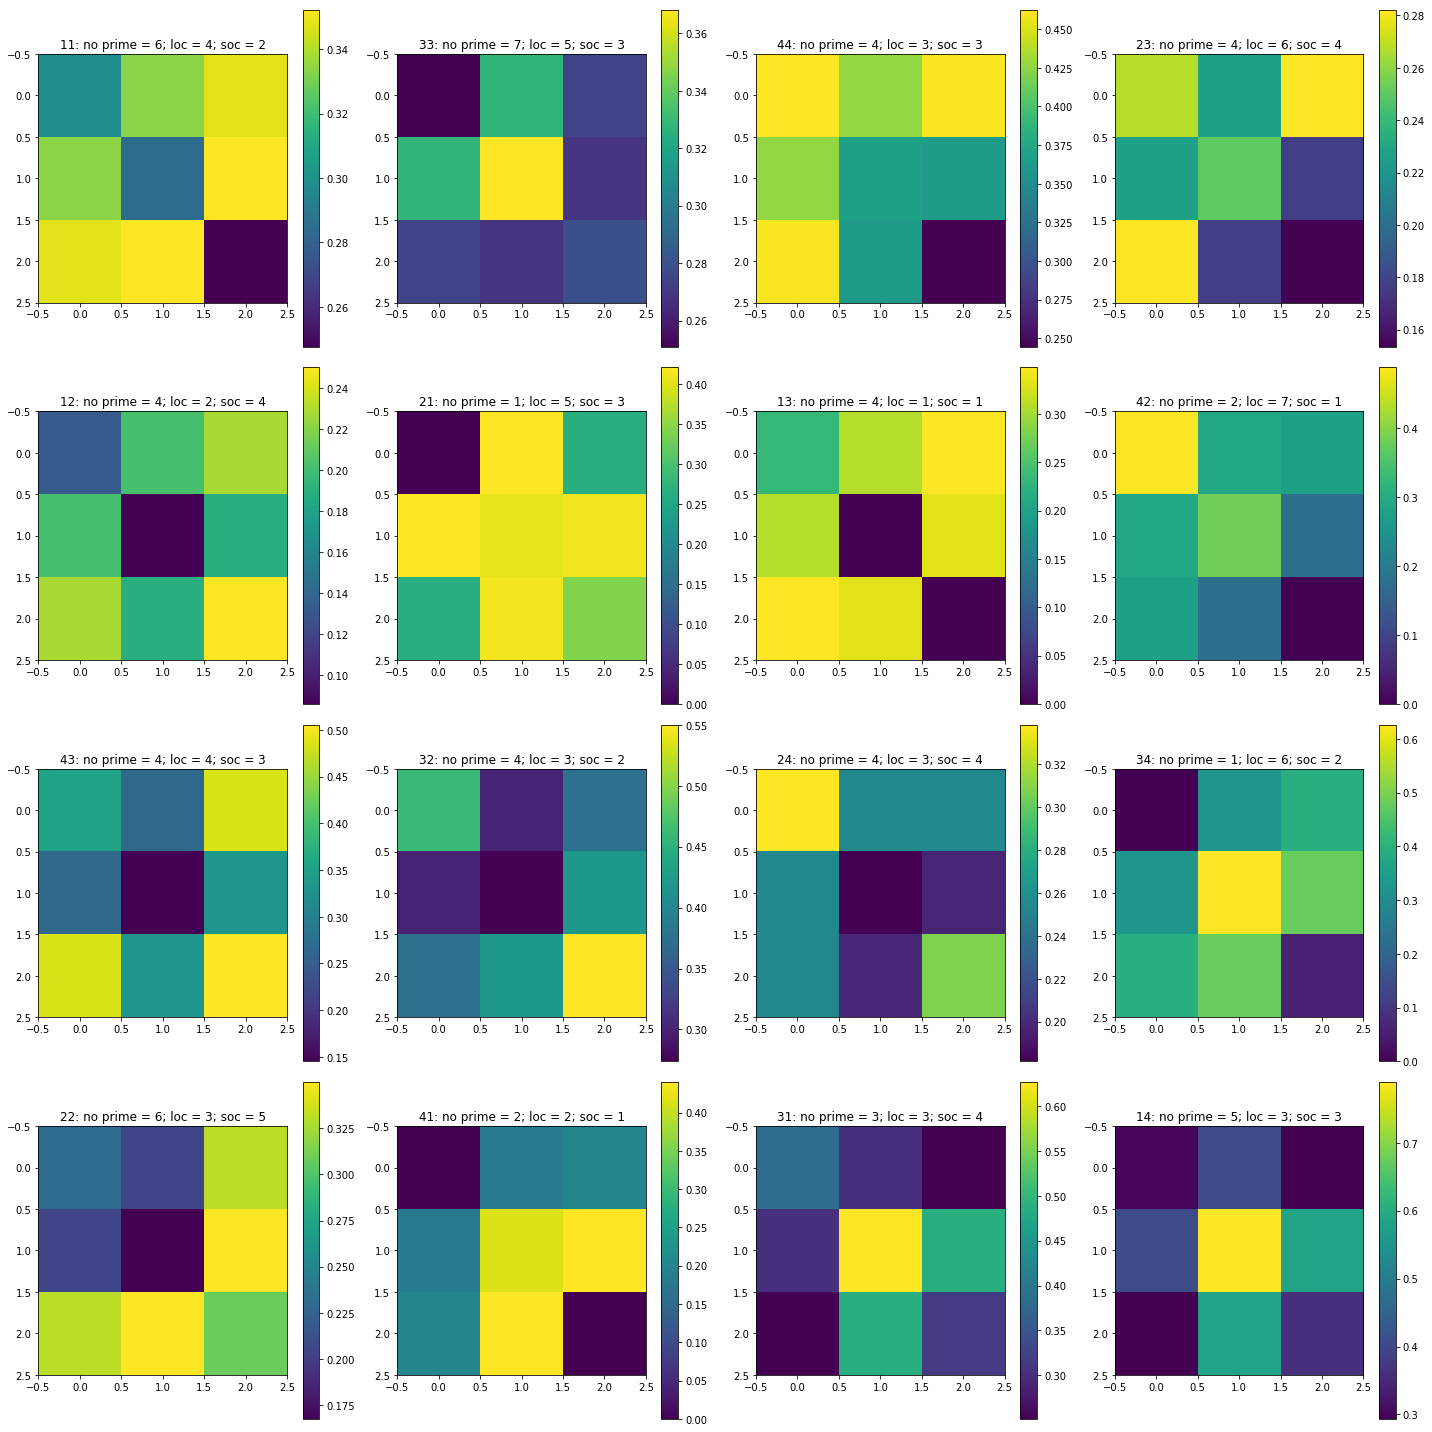

In [19]:
figure, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))

i = 0
j = 0
for key in j_bins:
    # Make the plot
    im = axes[j, i].imshow(j_bins[key])
    
    #colorbar
    im.set_clim()
    figure.colorbar(im, ax=axes[j, i])
    
    #set title
    none_n = sums[key][1]
    loc_n = sums[key][2]
    soc_n = sums[key][3]
    axes[j, i].set_title(str(key) + ': no prime = ' + str(none_n) + '; loc = ' + str(loc_n) + '; soc = ' + str(soc_n))
    
    #changing i, j for next graph placement
    if i == 3:
        i = 0
        j += 1
    else:
        i += 1
    figure.tight_layout()

## E. Averaging across stories
### 1. Compute

In [20]:
# Concatenate Matrices along the third dimension
count = 0
for key in j_bins:
    # ONLY KEEP TEMPORARILY
    # Replace zeros with nans
    j_bins[key][j_bins[key] <= 0] = float('Nan')
    if count == 0:
        all_j_bins = j_bins[key]
        count =+ 1
    else:
        all_j_bins = np.dstack((all_j_bins, j_bins[key]))

# NanMean
avg_all_j_bins_actual = np.nanmean(all_j_bins, axis = 2)

### 2. Plot

[Text(0, 0, 'NP'), Text(0, 0, 'L'), Text(0, 0, 'S')]

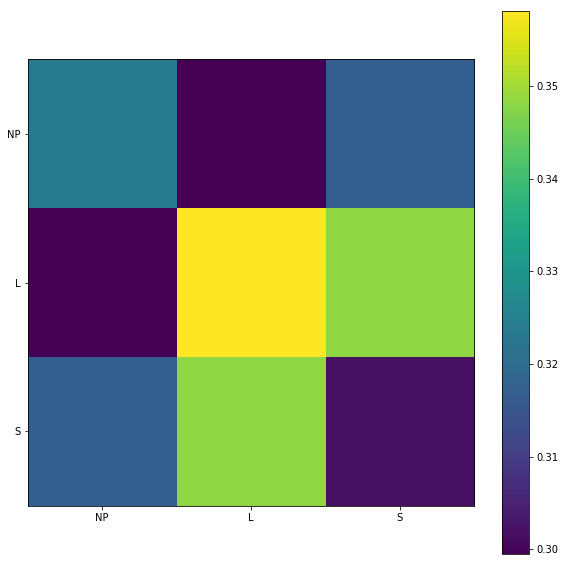

In [21]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
im = ax.imshow(avg_all_j_bins_actual)

fig.colorbar(im)

# X ticks
x_label_list = ['NP', 'L', 'S']
ax.set_xticks([0,1,2])
ax.set_xticklabels(x_label_list)

# Y ticks
y_label_list = ['NP', 'L', 'S']
ax.set_yticks([0,1,2])
ax.set_yticklabels(x_label_list)


# V. Permutation Testing
## A. Permute jc_array
## - mask data to bin the types of comparisons
## - average the types of comparisons
## - organize the types of comparisons in 3 x 3 matrix
## - append the resulting matrix into array with other permutations' matrices

In [22]:
this = np.array([[1,2,3],[4,5,6],[7,8,9]])
print(this)

randperm = np.random.permutation(3)
print(randperm)
this = this[randperm, :]
print(this)
this.shape[1]


[[1 2 3]
 [4 5 6]
 [7 8 9]]
[1 2 0]
[[4 5 6]
 [7 8 9]
 [1 2 3]]


3

In [23]:
N_perms = 1000
count_it = 0
sim_vals = []
for i in range(0, N_perms):
    ## permute the rows and columns of jc_array to randomize the eventual binning of jaccard indices
    rp_jc_array = {}
    for key in all_keys:
        # Deep copy the original array
        this_array = np.copy(jc_array[key])
        # Generate a permutation
        this_perm = np.random.permutation(this_array.shape[0])
        # Permute the columns
        this_array = this_array[:, this_perm]
        # Permute the rows
        this_array = this_array[this_perm, :]
        # Put in Dictionary
        rp_jc_array[key] = this_array
    
    ## Binning
    j_bins = {}

    for key in rp_jc_array:
        this_jbin = np.zeros((3,3))
        ######## NP - NP
        # Making the Mask
        this_mask = np.copy(mask[key])
        # Zero out all but '9's
        this_mask[this_mask != 9] = 0
        # Zero out diagonal
        n = this_mask.shape[0]
        this_mask[range(n), range(n)] = 0
        # Zero out lower triangle
        this_mask = np.triu(this_mask, k = 0)
        # Turn '9's into '1's
        this_mask[this_mask > 0] = 1
        # Multiplying the mask by the Jaccard Index Array
        masked_array =  this_mask * rp_jc_array[key]
        # Iterate through elements in array to add values and count how many there are
        count = 0
        val_sum = 0
        for x in masked_array:
            for y in x:
                if y > 0:
                    val_sum += y
                    count += 1
        # Putting the average masked value in this_jbin
        if count != 0:
            this_jbin[0,0] = val_sum/count
        ######## NP - loc
        # Making the Mask
        this_mask = np.copy(mask[key])
        # Zero out all but '15's
        this_mask[this_mask != 15] = 0
        # Zero out diagonal
        n = this_mask.shape[0]
        this_mask[range(n), range(n)] = 0
        # Zero out lower triangle
        this_mask = np.triu(this_mask, k = 0)
        # Turn '15's into '1's
        this_mask[this_mask > 0] = 1
        # Multiplying the mask by the Jaccard Index Array
        masked_array =  this_mask * rp_jc_array[key]
        # Iterate through elements in array to add values and count how many there are
        count = 0
        val_sum = 0
        for x in masked_array:
            for y in x:
                if y > 0:
                    val_sum += y
                    count += 1
        # Putting the average masked value in this_jbin
        if count != 0:
            this_jbin[0,1] = val_sum/count
            this_jbin[1,0] = val_sum/count
        ######## NP - soc
        # Making the Mask
        this_mask = np.copy(mask[key])
        # Zero out all but '21's
        this_mask[this_mask != 21] = 0
        # Zero out diagonal
        n = this_mask.shape[0]
        this_mask[range(n), range(n)] = 0
        # Zero out lower triangle
        this_mask = np.triu(this_mask, k = 0)
        # Turn '21's into '1's
        this_mask[this_mask > 0] = 1
        # Multiplying the mask by the Jaccard Index Array
        masked_array =  this_mask * rp_jc_array[key]
        # Iterate through elements in array to add values and count how many there are
        count = 0
        val_sum = 0
        for x in masked_array:
            for y in x:
                if y > 0:
                    val_sum += y
                    count += 1
        # Putting the average masked value in this_jbin
        if count != 0:
            this_jbin[0,2] = val_sum/count
            this_jbin[2,0] = val_sum/count
        ######## loc - loc
        # Making the Mask
        this_mask = np.copy(mask[key])
        # Zero out all but '25's
        this_mask[this_mask != 25] = 0
        # Zero out diagonal
        n = this_mask.shape[0]
        this_mask[range(n), range(n)] = 0
        # Zero out lower triangle
        this_mask = np.triu(this_mask, k = 0)
        # Turn '25's into '1's
        this_mask[this_mask > 0] = 1
        # Multiplying the mask by the Jaccard Index Array
        masked_array =  this_mask * rp_jc_array[key]
        # Iterate through elements in array to add values and count how many there are
        count = 0
        val_sum = 0
        for x in masked_array:
            for y in x:
                if y > 0:
                    val_sum += y
                    count += 1
        # Putting the average masked value in this_jbin
        if count != 0:
            this_jbin[1,1] = val_sum/count
            this_jbin[1,1] = val_sum/count
        ######## loc - soc
        # Making the Mask
        this_mask = np.copy(mask[key])
        # Zero out all but '35's
        this_mask[this_mask != 35] = 0
        # Zero out diagonal
        n = this_mask.shape[0]
        this_mask[range(n), range(n)] = 0
        # Zero out lower triangle
        this_mask = np.triu(this_mask, k = 0)
        # Turn '35's into '1's
        this_mask[this_mask > 0] = 1
        # Multiplying the mask by the Jaccard Index Array
        masked_array =  this_mask * rp_jc_array[key]
        # Iterate through elements in array to add values and count how many there are
        count = 0
        val_sum = 0
        for x in masked_array:
            for y in x:
                if y > 0:
                    val_sum += y
                    count += 1
        # Putting the average masked value in this_jbin
        if count != 0:
            this_jbin[1,2] = val_sum/count
            this_jbin[2,1] = val_sum/count
        ######## soc - soc
        # Making the Mask
        this_mask = np.copy(mask[key])
        # Zero out all but '49's
        this_mask[this_mask != 49] = 0
        # Zero out diagonal
        n = this_mask.shape[0]
        this_mask[range(n), range(n)] = 0
        # Zero out lower triangle
        this_mask = np.triu(this_mask, k = 0)
        # Turn '49's into '1's
        this_mask[this_mask > 0] = 1
        # Multiplying the mask by the Jaccard Index Array
        masked_array =  this_mask * rp_jc_array[key]
        # Iterate through elements in array to add values and count how many there are
        count = 0
        val_sum = 0
        for x in masked_array:
            for y in x:
                if y > 0:
                    val_sum += y
                    count += 1
        # Putting the average masked value in this_jbin
        if count != 0:
            this_jbin[2,2] = val_sum/count
            this_jbin[2,2] = val_sum/count
        #######################################################################
        # Put this_jbin in j_bins dict
        j_bins[key] = this_jbin
        
    ## Avg across stories
    #Concatenate Matrices along the third dimension
    count = 0
    for key in j_bins:
        # ONLY KEEP TEMPORARILY
        # Replace zeros with nans
        j_bins[key][j_bins[key] <= 0] = float('Nan')
        if count == 0:
            all_j_bins = j_bins[key]
            count =+ 1
        else:
            all_j_bins = np.dstack((all_j_bins, j_bins[key]))

    # NanMean
    avg_all_j_bins = np.nanmean(all_j_bins, axis = 2)
    
    print(avg_all_j_bins)
    
    # Add avg_all_j_bins to others of other iterations
    if count_it == 0:
        all_perms = avg_all_j_bins
        count_it += 1
    else:
        all_perms = np.dstack((all_perms, avg_all_j_bins))
        
    # Calculate similarity values and append
    sim_vals.append(((avg_all_j_bins[1,1] + avg_all_j_bins[2,2])/2) - avg_all_j_bins[1,2])


[[0.34795619 0.34863347 0.35873813]
 [0.34863347 0.31937366 0.3115695 ]
 [0.35873813 0.3115695  0.30566388]]
[[0.35720683 0.3214763  0.32630297]
 [0.3214763  0.36969738 0.30290056]
 [0.32630297 0.30290056 0.32512482]]
[[0.3715488  0.31902451 0.32265652]
 [0.31902451 0.32044833 0.33649229]
 [0.32265652 0.33649229 0.31064786]]
[[0.35026893 0.34491775 0.35935056]
 [0.34491775 0.30944486 0.33056843]
 [0.35935056 0.33056843 0.32180678]]
[[0.29823557 0.34782552 0.34837502]
 [0.34782552 0.27196751 0.30100508]
 [0.34837502 0.30100508 0.29667418]]
[[0.28727379 0.30185489 0.31521325]
 [0.30185489 0.34222645 0.3623794 ]
 [0.31521325 0.3623794  0.36943959]]
[[0.31838248 0.35870593 0.34819298]
 [0.35870593 0.30357541 0.29873056]
 [0.34819298 0.29873056 0.33572703]]
[[0.33999489 0.34497342 0.35703392]
 [0.34497342 0.3068332  0.33457657]
 [0.35703392 0.33457657 0.36775482]]
[[0.30975933 0.34708691 0.34110292]
 [0.34708691 0.35823985 0.33007344]
 [0.34110292 0.33007344 0.28080705]]
[[0.29601664 0.3090

 [0.288642   0.32231692 0.29199774]]
[[0.30065443 0.29183329 0.34004394]
 [0.29183329 0.34805946 0.35388257]
 [0.34004394 0.35388257 0.35689473]]
[[0.32547141 0.3363147  0.34860037]
 [0.3363147  0.36909672 0.32041623]
 [0.34860037 0.32041623 0.29674915]]
[[0.3584426  0.33069017 0.34844299]
 [0.33069017 0.29388003 0.32972752]
 [0.34844299 0.32972752 0.31154608]]
[[0.3357645  0.30581323 0.31573149]
 [0.30581323 0.35559677 0.32166216]
 [0.31573149 0.32166216 0.36192801]]
[[0.31976801 0.33987401 0.34721035]
 [0.33987401 0.31498747 0.33062519]
 [0.34721035 0.33062519 0.36023379]]
[[0.33152603 0.32697903 0.34066837]
 [0.32697903 0.37185971 0.3062387 ]
 [0.34066837 0.3062387  0.24891423]]
[[0.35138058 0.34999436 0.32788315]
 [0.34999436 0.34290152 0.29004535]
 [0.32788315 0.29004535 0.22620137]]
[[0.31167285 0.35299858 0.33504442]
 [0.35299858 0.32227368 0.30164285]
 [0.33504442 0.30164285 0.30346903]]
[[0.31992072 0.3390795  0.33242537]
 [0.3390795  0.33377016 0.33362945]
 [0.33242537 0.3336

[[0.3167695  0.34783496 0.33882927]
 [0.34783496 0.36031912 0.32600597]
 [0.33882927 0.32600597 0.26741464]]
[[0.29625714 0.3042343  0.32797609]
 [0.3042343  0.36956925 0.37232547]
 [0.32797609 0.37232547 0.40841822]]
[[0.29244383 0.31020889 0.29896789]
 [0.31020889 0.3062844  0.36927263]
 [0.29896789 0.36927263 0.34652479]]
[[0.3049439  0.3410699  0.33516694]
 [0.3410699  0.31312756 0.32149323]
 [0.33516694 0.32149323 0.36326158]]
[[0.32178316 0.30066452 0.32366581]
 [0.30066452 0.32657724 0.31780805]
 [0.32366581 0.31780805 0.36120922]]
[[0.34004802 0.34197555 0.3109744 ]
 [0.34197555 0.30078609 0.35140226]
 [0.3109744  0.35140226 0.34858974]]
[[0.2962306  0.30809998 0.32984045]
 [0.30809998 0.33646224 0.34907904]
 [0.32984045 0.34907904 0.41261666]]
[[0.30799756 0.29239348 0.34768615]
 [0.29239348 0.29382312 0.34457291]
 [0.34768615 0.34457291 0.39059143]]
[[0.27125126 0.31646816 0.35911946]
 [0.31646816 0.35788607 0.35128558]
 [0.35911946 0.35128558 0.31374231]]
[[0.30735329 0.3258

[[0.30148077 0.32004446 0.32112563]
 [0.32004446 0.3425521  0.33105972]
 [0.32112563 0.33105972 0.3240124 ]]
[[0.2999424  0.31443517 0.35408054]
 [0.31443517 0.32529522 0.32329939]
 [0.35408054 0.32329939 0.35727691]]
[[0.34435987 0.36348783 0.30783776]
 [0.36348783 0.37710408 0.27657433]
 [0.30783776 0.27657433 0.30472446]]
[[0.34871896 0.32716523 0.33671995]
 [0.32716523 0.27975977 0.36876776]
 [0.33671995 0.36876776 0.36367081]]
[[0.34126205 0.35385044 0.30990843]
 [0.35385044 0.31552562 0.3175982 ]
 [0.30990843 0.3175982  0.30712738]]
[[0.29101133 0.34710692 0.35716965]
 [0.34710692 0.30196476 0.332046  ]
 [0.35716965 0.332046   0.34793767]]
[[0.29522267 0.32742266 0.3150096 ]
 [0.32742266 0.3529509  0.3436553 ]
 [0.3150096  0.3436553  0.39565502]]
[[0.25536728 0.35950703 0.32281988]
 [0.35950703 0.32028165 0.34201255]
 [0.32281988 0.34201255 0.34257658]]
[[0.31460741 0.33697764 0.30113184]
 [0.33697764 0.35164836 0.32316133]
 [0.30113184 0.32316133 0.31548049]]
[[0.33301283 0.3271

 [0.32264049 0.31095664 0.26149002]]
[[0.33978159 0.32112642 0.30516909]
 [0.32112642 0.32694815 0.30642732]
 [0.30516909 0.30642732 0.27965024]]
[[0.28838531 0.35808429 0.3518032 ]
 [0.35808429 0.3181756  0.32548211]
 [0.3518032  0.32548211 0.34715028]]
[[0.34748028 0.30564831 0.3559263 ]
 [0.30564831 0.35828867 0.32974454]
 [0.3559263  0.32974454 0.37440604]]
[[0.3059981  0.31265959 0.31676347]
 [0.31265959 0.35697192 0.32596256]
 [0.31676347 0.32596256 0.33849442]]
[[0.34667507 0.33116757 0.34257122]
 [0.33116757 0.29580247 0.32178581]
 [0.34257122 0.32178581 0.35366502]]
[[0.33675716 0.35123441 0.30910803]
 [0.35123441 0.34829928 0.31049501]
 [0.30910803 0.31049501 0.27180588]]
[[0.29650321 0.32101374 0.34547374]
 [0.32101374 0.33187698 0.34062446]
 [0.34547374 0.34062446 0.38746455]]
[[0.28333513 0.3419387  0.31184575]
 [0.3419387  0.30961375 0.38515626]
 [0.31184575 0.38515626 0.30517136]]
[[0.32256896 0.32949239 0.32915681]
 [0.32949239 0.30155552 0.3212511 ]
 [0.32915681 0.3212

[[0.28902604 0.35237249 0.31767973]
 [0.35237249 0.33711358 0.32320912]
 [0.31767973 0.32320912 0.33221005]]
[[0.31230729 0.32710155 0.31955367]
 [0.32710155 0.29071422 0.33321672]
 [0.31955367 0.33321672 0.35076932]]
[[0.30763495 0.31383989 0.29714518]
 [0.31383989 0.33966799 0.34653391]
 [0.29714518 0.34653391 0.3697237 ]]
[[0.32221874 0.33860007 0.33107645]
 [0.33860007 0.32128418 0.33168451]
 [0.33107645 0.33168451 0.39317578]]
[[0.31389953 0.32159986 0.28502322]
 [0.32159986 0.30477836 0.32299777]
 [0.28502322 0.32299777 0.38929342]]
[[0.3038034  0.34879816 0.32572424]
 [0.34879816 0.31195818 0.32211203]
 [0.32572424 0.32211203 0.3191457 ]]
[[0.33454686 0.3313689  0.32357167]
 [0.3313689  0.32272116 0.30043615]
 [0.32357167 0.30043615 0.36151383]]
[[0.3033164  0.30432011 0.31730649]
 [0.30432011 0.36112476 0.32983547]
 [0.31730649 0.32983547 0.3513577 ]]
[[0.27950269 0.31401624 0.30862544]
 [0.31401624 0.36179498 0.34625942]
 [0.30862544 0.34625942 0.31837633]]
[[0.30193342 0.3131

 [0.3506025  0.32136925 0.35286862]]
[[0.30868212 0.30178022 0.30467685]
 [0.30178022 0.36778001 0.35055511]
 [0.30467685 0.35055511 0.38060746]]
[[0.33198344 0.35907254 0.325913  ]
 [0.35907254 0.33955514 0.29444081]
 [0.325913   0.29444081 0.30319295]]
[[0.32852986 0.337181   0.30882618]
 [0.337181   0.33465691 0.33343864]
 [0.30882618 0.33343864 0.28469676]]
[[0.36626088 0.35248215 0.32097293]
 [0.35248215 0.33730659 0.29690632]
 [0.32097293 0.29690632 0.3116602 ]]
[[0.32365857 0.33365958 0.30329235]
 [0.33365958 0.32214177 0.34542467]
 [0.30329235 0.34542467 0.32914108]]
[[0.34166382 0.32591185 0.36299349]
 [0.32591185 0.29092814 0.34548521]
 [0.36299349 0.34548521 0.36127036]]
[[0.34272595 0.34089938 0.32526963]
 [0.34089938 0.31887107 0.31791618]
 [0.32526963 0.31791618 0.34383964]]
[[0.29217595 0.31897843 0.34665675]
 [0.31897843 0.35835653 0.30474984]
 [0.34665675 0.30474984 0.33971896]]
[[0.27904116 0.31674486 0.3328949 ]
 [0.31674486 0.36376092 0.33374327]
 [0.3328949  0.3337

[[0.27638002 0.32012382 0.32903206]
 [0.32012382 0.30199658 0.37655526]
 [0.32903206 0.37655526 0.41005001]]
[[0.31243869 0.34105027 0.34524399]
 [0.34105027 0.27690461 0.30888883]
 [0.34524399 0.30888883 0.33344615]]
[[0.3123194  0.33970294 0.30831984]
 [0.33970294 0.35989312 0.32903447]
 [0.30831984 0.32903447 0.29789091]]
[[0.29185546 0.32640473 0.31475936]
 [0.32640473 0.33101643 0.35340238]
 [0.31475936 0.35340238 0.33083002]]
[[0.31620009 0.32203286 0.32743531]
 [0.32203286 0.35669087 0.3342461 ]
 [0.32743531 0.3342461  0.38822378]]
[[0.35988884 0.37111242 0.32101108]
 [0.37111242 0.2787224  0.32507341]
 [0.32101108 0.32507341 0.27909029]]
[[0.26612153 0.31823062 0.33242528]
 [0.31823062 0.35592278 0.36305463]
 [0.33242528 0.36305463 0.43524841]]
[[0.28638347 0.33206393 0.35541571]
 [0.33206393 0.30666863 0.32872229]
 [0.35541571 0.32872229 0.35571918]]
[[0.31432334 0.31472524 0.30345451]
 [0.31472524 0.34595249 0.36277574]
 [0.30345451 0.36277574 0.26306838]]
[[0.28128762 0.3446

[[0.31565878 0.33027865 0.31665218]
 [0.33027865 0.35591119 0.31937075]
 [0.31665218 0.31937075 0.30304281]]
[[0.31003004 0.36836656 0.33136489]
 [0.36836656 0.32922095 0.29048079]
 [0.33136489 0.29048079 0.27256189]]
[[0.2721071  0.31488715 0.32165103]
 [0.31488715 0.38657024 0.33346409]
 [0.32165103 0.33346409 0.39300432]]
[[0.29656771 0.3429637  0.33785384]
 [0.3429637  0.33397808 0.33504674]
 [0.33785384 0.33504674 0.30428288]]
[[0.32734834 0.34269571 0.33147956]
 [0.34269571 0.34258522 0.33180708]
 [0.33147956 0.33180708 0.35509096]]
[[0.31277819 0.32450604 0.34699046]
 [0.32450604 0.36071038 0.34829895]
 [0.34699046 0.34829895 0.30437407]]
[[0.35763657 0.32114039 0.34835105]
 [0.32114039 0.29910987 0.34641833]
 [0.34835105 0.34641833 0.3401938 ]]
[[0.30505012 0.30009585 0.35670213]
 [0.30009585 0.30849465 0.32947154]
 [0.35670213 0.32947154 0.433475  ]]
[[0.33650149 0.31147018 0.33440059]
 [0.31147018 0.398895   0.33192069]
 [0.33440059 0.33192069 0.30896644]]
[[0.27960177 0.2999

 [0.34623765 0.30753291 0.3097805 ]]
[[0.32497899 0.32453004 0.31993421]
 [0.32453004 0.31862478 0.32219678]
 [0.31993421 0.32219678 0.29390152]]
[[0.28157981 0.28092637 0.29666597]
 [0.28092637 0.31755815 0.38598915]
 [0.29666597 0.38598915 0.41527053]]
[[0.28835091 0.3288117  0.33501327]
 [0.3288117  0.33694619 0.33690159]
 [0.33501327 0.33690159 0.3801497 ]]
[[0.30320474 0.33716263 0.32001586]
 [0.33716263 0.30837069 0.31928576]
 [0.32001586 0.31928576 0.32415977]]
[[0.32658728 0.30403785 0.32607863]
 [0.30403785 0.38407342 0.30797146]
 [0.32607863 0.30797146 0.33975504]]
[[0.29683607 0.33914222 0.3501874 ]
 [0.33914222 0.34673089 0.31881947]
 [0.3501874  0.31881947 0.31405709]]
[[0.27338297 0.32918178 0.31547081]
 [0.32918178 0.34317335 0.33964928]
 [0.31547081 0.33964928 0.37216866]]
[[0.28833124 0.33031389 0.3398984 ]
 [0.33031389 0.34628366 0.38216249]
 [0.3398984  0.38216249 0.36357756]]
[[0.29938642 0.30828478 0.34059153]
 [0.30828478 0.30760307 0.35466822]
 [0.34059153 0.3546

[[0.3239949  0.32271251 0.34738795]
 [0.32271251 0.31325946 0.31702791]
 [0.34738795 0.31702791 0.34869593]]
[[0.28376427 0.34482696 0.33840588]
 [0.34482696 0.35135021 0.31985619]
 [0.33840588 0.31985619 0.3497854 ]]
[[0.36082862 0.30965501 0.34836715]
 [0.30965501 0.31996273 0.32635546]
 [0.34836715 0.32635546 0.36019706]]
[[0.33473544 0.33873929 0.35032107]
 [0.33873929 0.31135078 0.3067887 ]
 [0.35032107 0.3067887  0.27693903]]
[[0.2639924  0.36069226 0.32941282]
 [0.36069226 0.35127624 0.3414597 ]
 [0.32941282 0.3414597  0.30557832]]
[[0.33510847 0.31919428 0.3496371 ]
 [0.31919428 0.27949835 0.31120152]
 [0.3496371  0.31120152 0.31560963]]
[[0.30510759 0.37071132 0.32860559]
 [0.37071132 0.34501314 0.31309176]
 [0.32860559 0.31309176 0.34783543]]
[[0.33563361 0.34301078 0.29688102]
 [0.34301078 0.32674407 0.32257722]
 [0.29688102 0.32257722 0.29270855]]
[[0.3313652  0.31486125 0.29966653]
 [0.31486125 0.33779705 0.35738192]
 [0.29966653 0.35738192 0.3625184 ]]
[[0.31819044 0.3417

[[0.34070671 0.32271392 0.30443332]
 [0.32271392 0.34542813 0.31727119]
 [0.30443332 0.31727119 0.33746746]]
[[0.28772393 0.32949629 0.31623813]
 [0.32949629 0.41420529 0.33836504]
 [0.31623813 0.33836504 0.35360498]]
[[0.31609678 0.32555625 0.33640336]
 [0.32555625 0.32056009 0.34385504]
 [0.33640336 0.34385504 0.34889029]]
[[0.3039902  0.34817166 0.31584984]
 [0.34817166 0.28794068 0.33089898]
 [0.31584984 0.33089898 0.37833256]]
[[0.30827    0.33385971 0.36491235]
 [0.33385971 0.32017346 0.3254042 ]
 [0.36491235 0.3254042  0.3642921 ]]
[[0.29895269 0.34215971 0.32386891]
 [0.34215971 0.35564486 0.33668976]
 [0.32386891 0.33668976 0.30778718]]
[[0.3339276  0.34128505 0.33132659]
 [0.34128505 0.33111155 0.31927091]
 [0.33132659 0.31927091 0.28429448]]
[[0.32369733 0.30902292 0.32325383]
 [0.30902292 0.28798999 0.30648688]
 [0.32325383 0.30648688 0.34860071]]
[[0.33380995 0.34911139 0.35882143]
 [0.34911139 0.26749267 0.3175018 ]
 [0.35882143 0.3175018  0.31742699]]
[[0.30522715 0.3036

[[0.30084162 0.32078535 0.30369248]
 [0.32078535 0.36765604 0.34289955]
 [0.30369248 0.34289955 0.30165565]]
[[0.30706199 0.342584   0.33741807]
 [0.342584   0.33980879 0.33925233]
 [0.33741807 0.33925233 0.31028219]]
[[0.28115199 0.35595043 0.35219779]
 [0.35595043 0.39224753 0.33450224]
 [0.35219779 0.33450224 0.38330777]]
[[0.30084251 0.34278164 0.37172074]
 [0.34278164 0.30360305 0.3349709 ]
 [0.37172074 0.3349709  0.38264042]]
[[0.33318864 0.31665223 0.33311183]
 [0.31665223 0.35909959 0.37261547]
 [0.33311183 0.37261547 0.34986503]]
[[0.30303184 0.34027221 0.26709643]
 [0.34027221 0.40997072 0.34107297]
 [0.26709643 0.34107297 0.30100502]]
[[0.31905894 0.35947929 0.31475589]
 [0.35947929 0.34546292 0.32531534]
 [0.31475589 0.32531534 0.25246468]]
[[0.26318475 0.32163173 0.32896206]
 [0.32163173 0.33992853 0.34479742]
 [0.32896206 0.34479742 0.34711801]]
[[0.30822819 0.33435345 0.32367616]
 [0.33435345 0.32881533 0.308739  ]
 [0.32367616 0.308739   0.35218094]]
[[0.2926515  0.3251

In [24]:
print(key)

14


## B. Avg matrices and plot

[Text(0, 0, 'NP'), Text(0, 0, 'L'), Text(0, 0, 'S')]

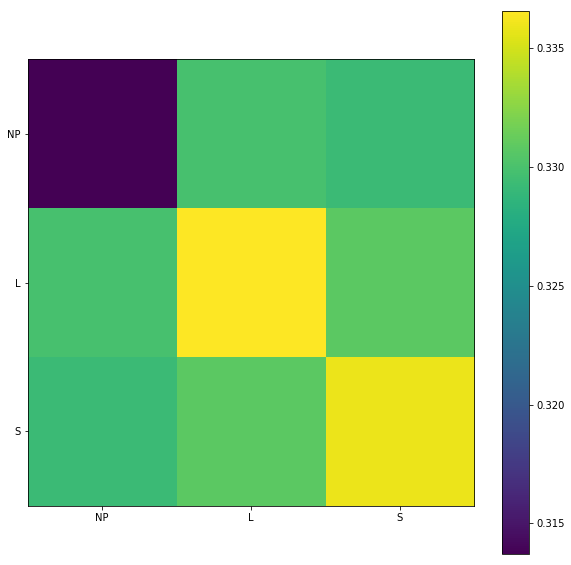

In [25]:
avg_perm = np.mean(all_perms, axis = 2)

fig, ax = plt.subplots(1,1, figsize=(10,10))
im = ax.imshow(avg_perm)

fig.colorbar(im)

# X ticks
x_label_list = ['NP', 'L', 'S']
ax.set_xticks([0,1,2])
ax.set_xticklabels(x_label_list)

# Y ticks
y_label_list = ['NP', 'L', 'S']
ax.set_yticks([0,1,2])
ax.set_yticklabels(x_label_list)

## C. Calculate p-value for each box and plot matrix of p-values

[Text(0, 0, 'NP'), Text(0, 0, 'L'), Text(0, 0, 'S')]

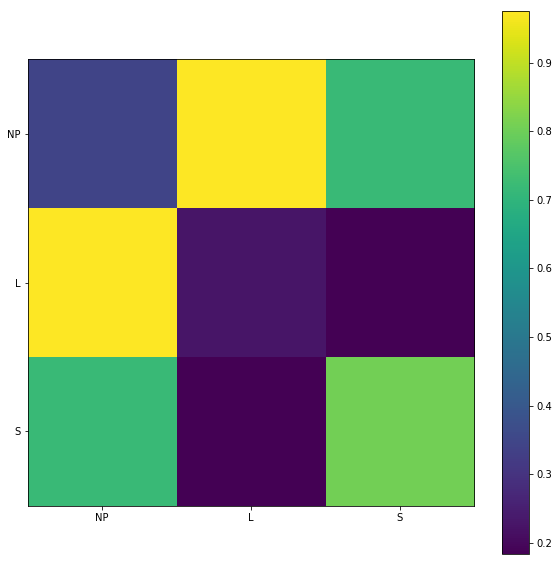

In [26]:
p_vals = np.zeros((3,3))

for i in range(0,3):
    for j in range(0, 3):
        these_vals = all_perms[i, j, :]
        p_vals[i,j] = ((these_vals > avg_all_j_bins_actual[i,j]).sum())/N_perms

# Plot
fig, ax = plt.subplots(1,1, figsize=(10,10))
im = ax.imshow(p_vals)

fig.colorbar(im)

# X ticks
x_label_list = ['NP', 'L', 'S']
ax.set_xticks([0,1,2])
ax.set_xticklabels(x_label_list)

# Y ticks
y_label_list = ['NP', 'L', 'S']
ax.set_yticks([0,1,2])
ax.set_yticklabels(x_label_list)

## D. Similarity of keypresses within a priming group
### 1. Calculate the actual similarity value

In [27]:
actual_sim_val = ((avg_all_j_bins_actual[1,1] + avg_all_j_bins_actual[2,2])/2) - avg_all_j_bins_actual[1,2]

### 2. Find the p-value this value

The p value is  0.807


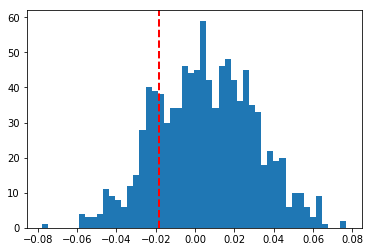

In [28]:
# convert list of PEs to np
sims = np.asarray(sim_vals)
# Plot the histogram
plt.hist(sims, bins = 50)
# Show the actual data
plt.axvline(x=actual_sim_val, color='r', linestyle='dashed', linewidth=2)
# Calculate the P-value
p_val = ((sims > actual_sim_val).sum())/1000
print('The p value is ', p_val)

In [61]:
avg_all_j_bins_actual

array([[0.27930343, 0.28417848, 0.28787559],
       [0.28417848, 0.33811263, 0.32587493],
       [0.28787559, 0.32587493, 0.28320346]])